In [19]:
import os
import sys
import random
from glob import glob
from copy import deepcopy
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

# enable use of local modules
repo_dir = '/grad/bwedig/mejiro'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

from mejiro.galaxy_galaxy import SampleGG, SampleSL2S, SampleBELLS
from mejiro.synthetic_image import SyntheticImage
from mejiro.engines.stpsf_engine import STPSFEngine
from mejiro.instruments.roman import Roman
from mejiro.exposure import Exposure
from mejiro.utils import util

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

In [20]:
strong_lens = SampleBELLS()

(array([-0.66209205,  0.39826423]), array([ 0.49845985, -0.29808303]))


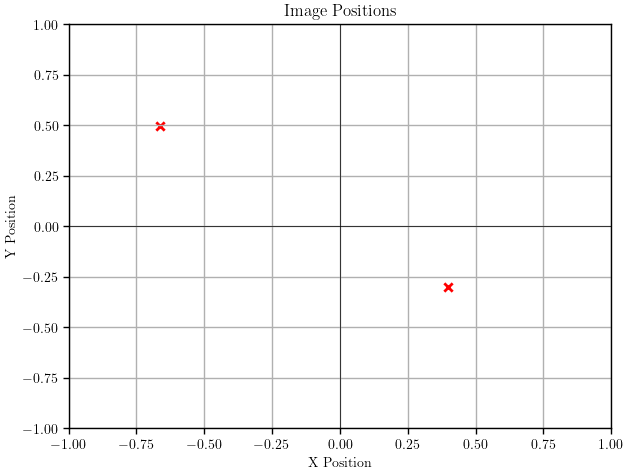

In [21]:
image_positions = strong_lens.get_image_positions()
pprint(image_positions)

plt.scatter(image_positions[0], image_positions[1], c='r', marker='x')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Image Positions')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [22]:
print(strong_lens.z_lens, strong_lens.z_source)

0.58 1.35


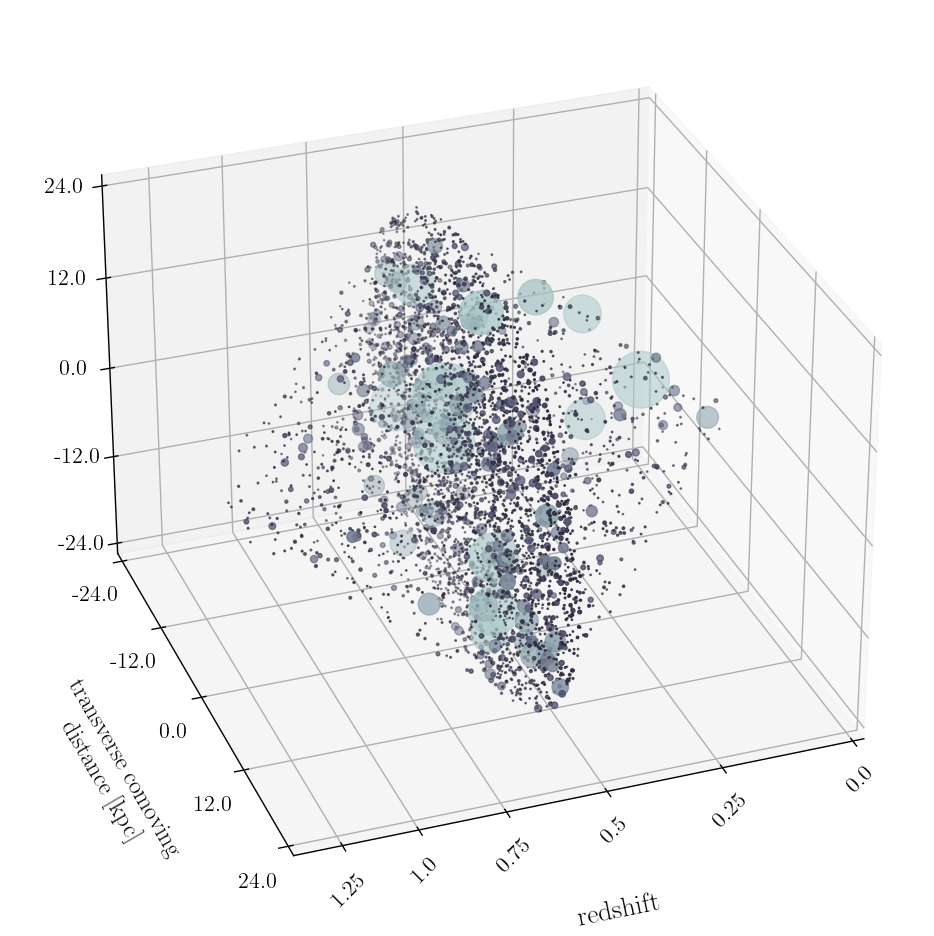

In [23]:
from pyHalo.preset_models import preset_model_from_name

CDM = preset_model_from_name('CDM')
# realization = CDM(round(strong_lens.z_lens), round(strong_lens.z_source), cone_opening_angle_arcsec=10)

zlens = round(strong_lens.z_lens, 2)
zsource = round(strong_lens.z_source, 2)
# zlens, zsource = 0.5, 2.5
realizationCDM = CDM(zlens, zsource, cone_opening_angle_arcsec=5)

fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
realizationCDM.plot(ax)

In [24]:
halo_lens_model_list, halo_redshift_array, kwargs_halos, _ = realizationCDM.lensing_quantities(
            add_mass_sheet_correction=True)

print(type(halo_lens_model_list))
print(type(halo_redshift_array))
print(type(kwargs_halos))

<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>


In [25]:
strong_lens.kwargs_lens += kwargs_halos
strong_lens.lens_redshift_list += list(halo_redshift_array)
strong_lens.lens_model_list += halo_lens_model_list

Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F129_1_2048_2048_5_101.npy


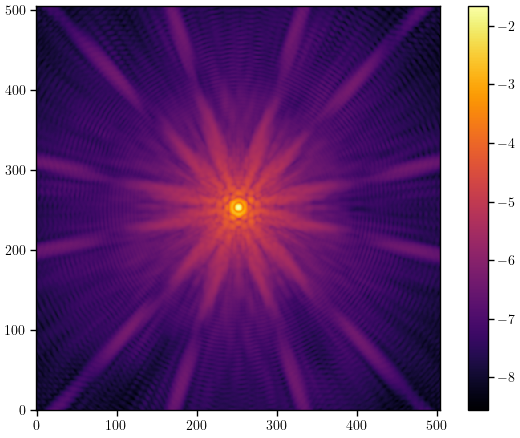

In [26]:
kwargs_psf = STPSFEngine.get_psf_kwargs('F129', 'SCA01', (2048, 2048), oversample=5, num_pix=101, check_cache=True, psf_cache_dir='/data/bwedig/mejiro/cached_psfs', verbose=True)

plt.imshow(np.log10(kwargs_psf['kernel_point_source']), cmap='inferno')
plt.colorbar()
plt.show()

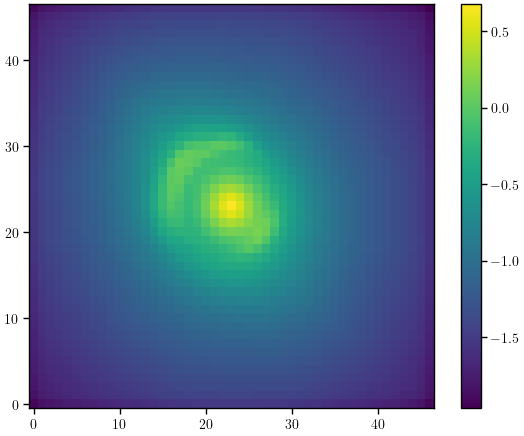

In [27]:
kwargs_numerics = {
        'supersampling_factor': 5,  # super sampling factor of (partial) high resolution ray-tracing
        'compute_mode': 'regular',  # 'regular' or 'adaptive'
        'supersampling_convolution': True,  # bool, if True, performs the supersampled convolution (either on regular or adaptive grid)
        'supersampling_kernel_size': None,  # size of the higher resolution kernel region (can be smaller than the original kernel). None leads to use the full size
        'flux_evaluate_indexes': None,  # bool mask, if None, it will evaluate all (sub) pixels
        'supersampled_indexes': None,  # bool mask of pixels to be computed in supersampled grid (only for adaptive mode)
        'compute_indexes': None,  # bool mask of pixels to be computed the PSF response (flux being added to). Only used for adaptive mode and can be set =likelihood mask.
        'point_source_supersampling_factor': 5,
}

synthetic_image = SyntheticImage(strong_lens=strong_lens,
                                     instrument=Roman(),
                                     band='F129',
                                     fov_arcsec=5,
                                     instrument_params={'detector': 'SCA01'},
                                     kwargs_numerics=kwargs_numerics,
                                     kwargs_psf=kwargs_psf,
                                     pieces=False,
                                     verbose=False)

plt.imshow(np.log10(synthetic_image.image))
plt.colorbar()
plt.show()

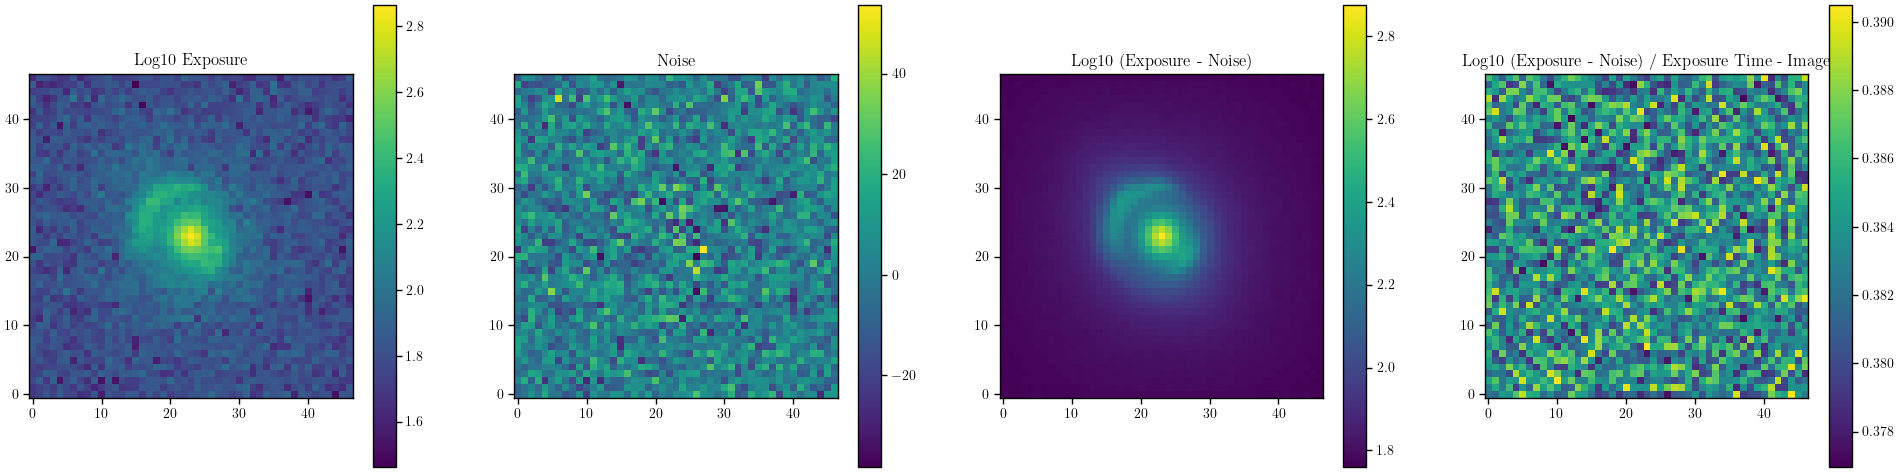

In [28]:
exposure = Exposure(synthetic_image,
                        exposure_time=146,
                        engine='galsim',
                        engine_params={'rng_seed': 2},
                        verbose=False)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))

im0 = axs[0].imshow(np.log10(exposure.exposure))
axs[0].set_title('Log10 Exposure')
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(exposure.noise)
axs[1].set_title('Noise')
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(np.log10(exposure.exposure - exposure.noise))
axs[2].set_title('Log10 (Exposure - Noise)')
fig.colorbar(im2, ax=axs[2])

im3 = axs[3].imshow(((exposure.exposure - exposure.noise) / 146) - synthetic_image.image)
axs[3].set_title('Log10 (Exposure - Noise) / Exposure Time - Image')
fig.colorbar(im3, ax=axs[3])

plt.show()